In [1]:
import yaml
from model_utils import GeneralizedMLP, FourierKAN, PirateNet
from model_utils import get_mse_loss, get_train_step
from model_utils import KeyHandler, sobol_sample
import jax.numpy as jnp
from flax import linen as nn
import optax
import numpy as np
from functools import partial
from tqdm import tqdm
import pandas as pd

In [2]:
from interpolated_funcs import circular_wave_interference

def get_model(config):
    if config["MODEL"] == "MLP":
        return GeneralizedMLP(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "KAN":
        return FourierKAN(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "PIRATE":
        return PirateNet(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            layer_sizes=config['layers'] # first is fourier
        )
    
def get_target_func(config):
    if experiment["learnable_func"] == "circular_wave_interference":
        learnable_func = circular_wave_interference

    learnable_func = partial(learnable_func, FREQ=experiment["FREQ"])
    return learnable_func

def sample_collocs(config):
    collocs = jnp.array(sobol_sample(np.array([config["X_MIN"],config["Y_MIN"]]), 
                                     np.array([config["X_MAX"],config["Y_MAX"]]), config["BS"]))
    return collocs

def train_model(config):    
    collocs = sample_collocs(config)

    model = get_model(config)
    variables = model.init(keygen.key(), collocs)
    loss_fn = get_mse_loss(model, MODEL=config["MODEL"])
    
    # Define a cosine decay learning rate schedule
    schedule_fn = optax.cosine_decay_schedule(
        init_value=1e-2,       # Initial learning rate
        decay_steps=config["EPOCHS"],  # Total number of decay steps
        alpha=1e-3             # Final learning rate multiplier
    )
    optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    opt_state = optimizer.init(variables['params'])
    train_step = get_train_step(model, optimizer, loss_fn)

    learnable_func = get_target_func(config)

    if config["MODEL"] != "KAN":
        variables["state"] = []

    # train always on same colloc points
    collocs = sample_collocs(experiment)
    losses = []

    loc_w = jnp.array([])
    for i in (pbar:= tqdm(range(experiment["EPOCHS"]))):
        params, state = variables['params'], variables['state']
        y = learnable_func(collocs).reshape(-1,1)
        params, opt_state, loss, loc_w = train_step(params, collocs, y,
                                                    opt_state, state, loc_w)
        variables = {'params': params, 'state':state}

        losses.append(loss)

        if i % 50 == 0: # dont waste a lot of time printing
            pbar.set_description(f"Loss {loss: .8f}")

    return variables

import pickle
def save_dict_to_file(dictionary, filename):
    """Saves a dictionary to a file using pickle."""
    with open(filename, 'wb') as file:
        pickle.dump(dictionary, file)

def load_dict_from_file(filename):
    """Loads a dictionary from a file using pickle."""
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [3]:
filename = "PIRATE_increase_params"
with open(f"{filename}.yaml", 'r') as file:
    config = yaml.safe_load(file)

keygen = KeyHandler(0)
config["experiments"].keys()

dict_keys(['increase_params_1', 'increase_params_2', 'increase_params_3', 'increase_params_4', 'increase_params_5'])

In [4]:
for exp_key in config["experiments"].keys():
    experiment = config["experiments"][exp_key]
    variables = train_model(experiment)
    save_dict_to_file(variables, f"trained_models/{exp_key}")

Loss  0.00000483: 100%|██████████| 2500/2500 [01:23<00:00, 29.99it/s]


In [5]:
def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

def get_l2_error(config, variables):
    model = get_model(config)
    learnable_func = get_target_func(experiment)
    
    N = 300
    X_1 = jnp.linspace(experiment["X_MIN"], experiment["X_MAX"], N)
    X_2 = jnp.linspace(experiment["Y_MIN"], experiment["Y_MAX"], N)
    X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
    coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)

    y = learnable_func(coords).reshape(-1,1)

    if config["MODEL"] == "KAN":
        y_hat = model.apply(variables, coords)
    else:
        y_hat = model.apply({"params": variables["params"]}, coords)
        
    err = l2_error(y_hat, y)
    
    return err

def sum_params(data, verbose=False):
    total = 0
    if isinstance(data, type(jnp.array([]))):  # If the current node is a leaf array
        return len(data.reshape(-1))
    elif isinstance(data, dict):  # If the current node is a dictionary
        for key, value in data.items():
            if verbose:
                print(f"Processing key: {key}")  # Print the current key
            branch_total = sum_params(value)  # Compute the total for this subbranch
            if verbose:
                print(f"Total parameters in subbranch '{key}': {branch_total}")
            total += branch_total
    
    return total

In [6]:
import pandas as pd

df = pd.DataFrame(config["experiments"]).T
df["params"] = -1
df["L2%"] = -1

for idx, exp_key in enumerate(config["experiments"].keys()):
    experiment = config["experiments"][exp_key]
    
    variables = load_dict_from_file(f"trained_models/{exp_key}")
    l2_err = get_l2_error(experiment, variables)

    df.loc[exp_key, "params"] = sum_params(variables["params"], verbose=False)
    df.loc[exp_key, "L2%"] = l2_err * 100

    print(f"Results from {exp_key}:")
    print(f"L2 {l2_err*100:.4f}%")
    print(f"#params {df.iloc[idx]['params']}")
    
df.to_csv(f'{filename}.csv')

Results from increase_params_1:
L2 35.4541%
#params 599
Results from increase_params_2:
L2 6.8927%
#params 2219
Results from increase_params_3:
L2 0.8113%
#params 8531
Results from increase_params_4:
L2 0.5160%
#params 20962
Results from increase_params_5:
L2 0.4046%
#params 33443


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from matplotlib import cm
import os

def plot_true_approx(config, variables, exp_key):
    model = get_model(config)
    learnable_func = get_target_func(config)  # Fixed to use 'config' instead of 'experiment'
    
    N = 300
    X_1 = jnp.linspace(config["X_MIN"], config["X_MAX"], N)  # Fixed to use 'config'
    X_2 = jnp.linspace(config["Y_MIN"], config["Y_MAX"], N)  # Fixed to use 'config'
    X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
    coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)

    y = learnable_func(coords).reshape(-1, 1)
    if config["MODEL"] == "KAN":
        y_hat = model.apply(variables, coords)
    else:
        y_hat = model.apply({"params": variables["params"]}, coords)

    y_hat = y_hat.reshape(-1, 1)

    # Compute the absolute error
    abs_error = jnp.abs(y - y_hat).reshape(-1, 1)

    # Create a figure and axis grid for the 3 subplots
    fig = plt.figure(figsize=(18, 6))

    # Plotting the approximated function (y_hat) on the left using the plasma colormap
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_trisurf(coords[:, 0], coords[:, 1], y_hat.flatten(), cmap=cm.plasma)
    ax1.set_title('Approximated Function (y_hat)')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('y_hat')

    # Plotting the true function (y) in the middle
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_trisurf(coords[:, 0], coords[:, 1], y.flatten(), cmap='viridis')
    ax2.set_title('True Function (y)')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('y')

    # Plotting the absolute error on the right
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_trisurf(coords[:, 0], coords[:, 1], abs_error.flatten(), cmap='inferno')
    ax3.set_title('Absolute Error')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('Error')

    # Adjust layout to ensure all plots fit well within the figure
    plt.tight_layout(pad=3.0)

    # Saving the figure
    save_folder = f'visuals/{filename}'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = os.path.join(save_folder, f'{exp_key}_plot.png')

    # Show the plot
    plt.show()

    # Save the plot to the specified path
    fig.savefig(save_path)

Results from increase_params_1:


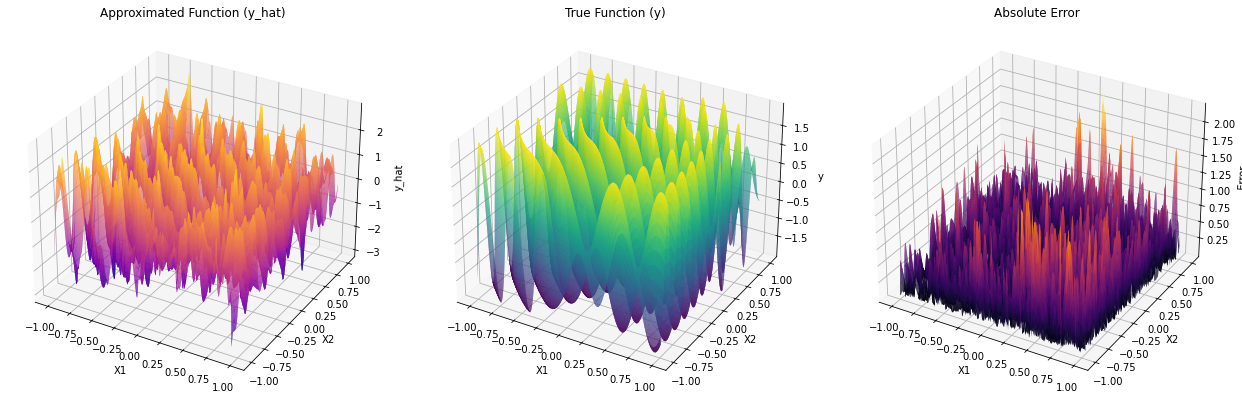

Results from increase_params_2:


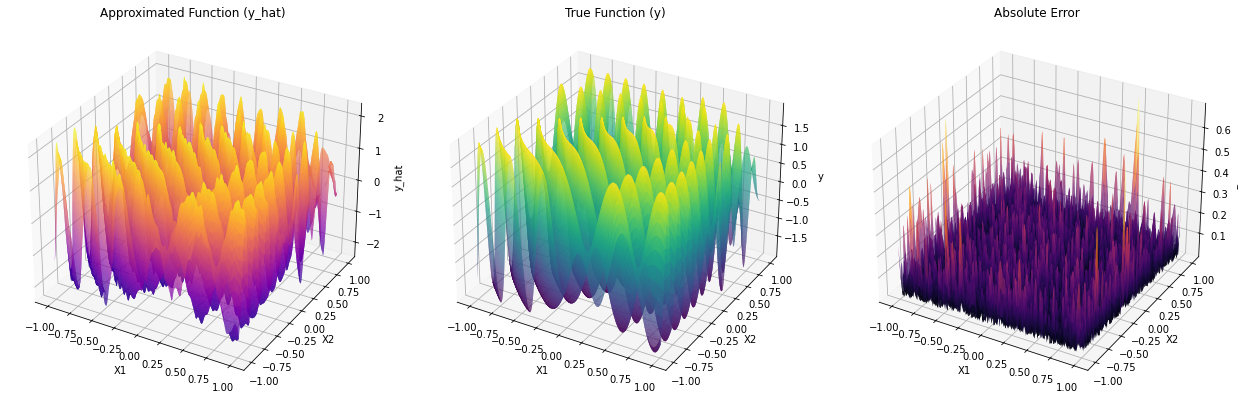

Results from increase_params_3:


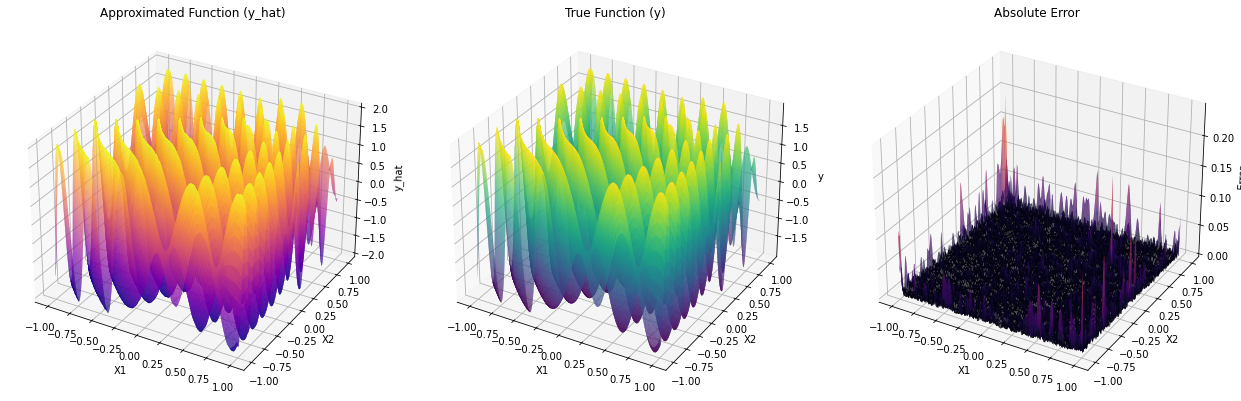

Results from increase_params_4:


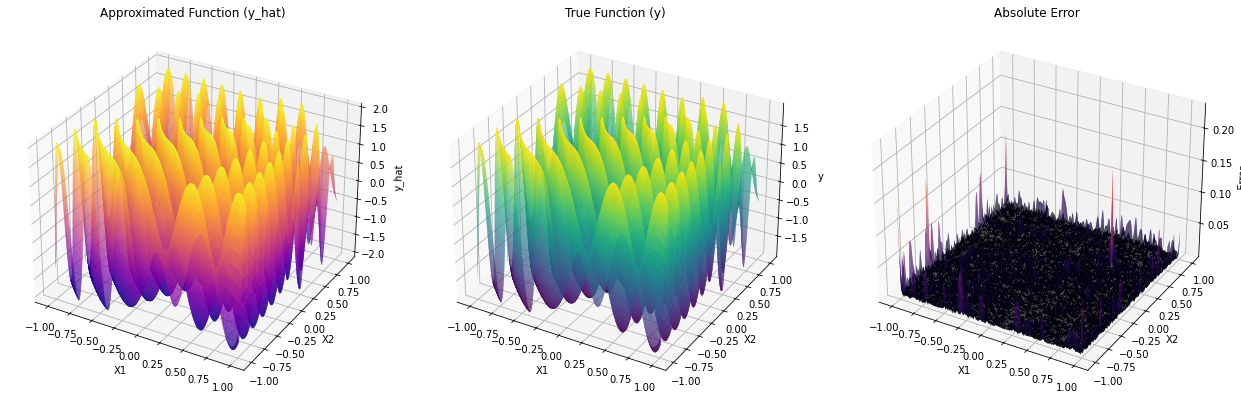

Results from increase_params_5:


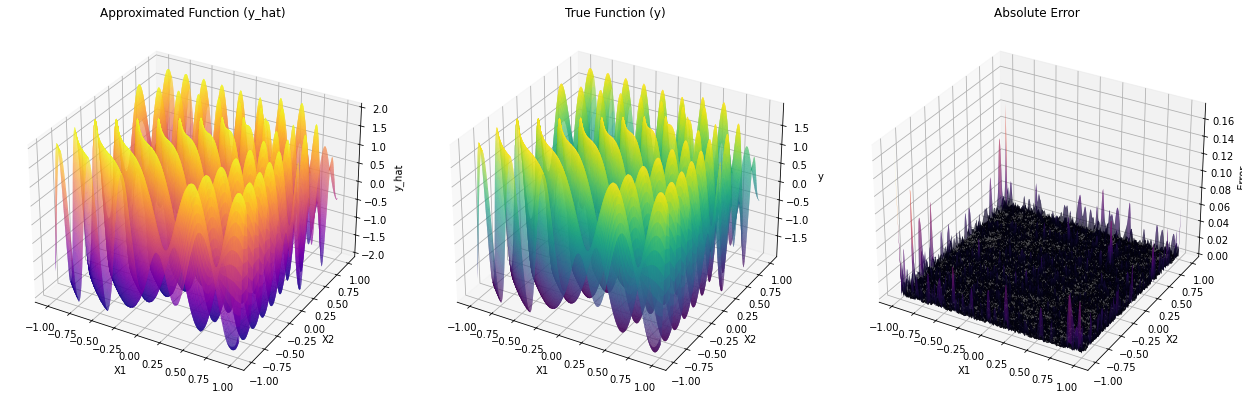

In [8]:
for exp_key in config["experiments"].keys():
    experiment = config["experiments"][exp_key]

    print(f"Results from {exp_key}:")
    variables = load_dict_from_file(f'trained_models/{exp_key}')
    plot_true_approx(experiment,variables, f'{exp_key}')